In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# ------------------------------------------------
# 2. RUTAS Y PARÁMETROS
# ------------------------------------------------
base_dir = "G:/Mi unidad/TESIS/MURA_2"  # Ajusta a tu ruta real
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

# Hiperparámetros
EPOCHS_FROZEN = 30      # Fase 1 (capas congeladas)
LEARNING_RATE_FROZEN = 1e-3  # Mayor tasa de aprendizaje

EPOCHS_UNFROZEN = 25    # Fase 2 (fine-tuning)
LEARNING_RATE_UNFROZEN = 1e-5
NUM_LAYERS_FROZEN = 100  # Solo congelamos 100 capas

# ------------------------------------------------
# 3. DATA AUGMENTATION
# ------------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ------------------------------------------------
# 4. CALCULAR PESOS DE CLASE
# ------------------------------------------------
y_train = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = {i: class_weights[i] for i in range(len(class_weights))}
print("\n🔹 Pesos de clase calculados:", class_weight)

# ------------------------------------------------
# 5. CARGAR MODELO PREENTRENADO (EfficientNetB4)
# ------------------------------------------------
base_model = EfficientNetB4(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Congelar solo las primeras 100 capas
for layer in base_model.layers[:-NUM_LAYERS_FROZEN]:
    layer.trainable = False

# Construir la "cabeza" densa
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# ------------------------------------------------
# 6. ENTRENAR FASE 1 (CAPAS PARCIALMENTE CONGELADAS)
# ------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_FROZEN),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.AUC(name="AUC"), "accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

print("\n=== Entrenamiento Fase 1 (capas parcialmente congeladas) ===")
history_frozen = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_FROZEN,
    callbacks=[early_stopping, reduce_on_plateau],
    class_weight=class_weight
)

# ------------------------------------------------
# 7. ENTRENAR FASE 2 (DESCONGELAR MÁS CAPAS)
# ------------------------------------------------
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_UNFROZEN),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name="AUC"), "accuracy"]
)

print("\n=== Entrenamiento Fase 2 (fine-tuning) ===")
history_unfrozen = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_UNFROZEN,
    callbacks=[early_stopping, reduce_on_plateau],
    class_weight=class_weight
)


Found 32004 images belonging to 2 classes.
Found 8001 images belonging to 2 classes.

🔹 Pesos de clase calculados: {0: 1.2194787379972565, 1: 0.8474737845567207}

=== Entrenamiento Fase 1 (capas parcialmente congeladas) ===
Epoch 1/30
4001/4001 [==============================] - 622s 151ms/step - loss: 0.7027 - AUC: 0.5027 - accuracy: 0.5032 - val_loss: 0.6926 - val_AUC: 0.5141 - val_accuracy: 0.5411 - lr: 0.0010
Epoch 2/30
4001/4001 [==============================] - 605s 151ms/step - loss: 0.6948 - AUC: 0.5193 - accuracy: 0.5142 - val_loss: 0.6925 - val_AUC: 0.5239 - val_accuracy: 0.4252 - lr: 0.0010
Epoch 3/30
4001/4001 [==============================] - 599s 150ms/step - loss: 0.6921 - AUC: 0.5331 - accuracy: 0.5139 - val_loss: 0.6929 - val_AUC: 0.5661 - val_accuracy: 0.5951 - lr: 0.0010
Epoch 4/30
4001/4001 [==============================] - 606s 151ms/step - loss: 0.6926 - AUC: 0.5293 - accuracy: 0.5270 - val_loss: 0.6835 - val_AUC: 0.6013 - val_accuracy: 0.5969 - lr: 0.0010
Epoc

In [ ]:
HISTORICO

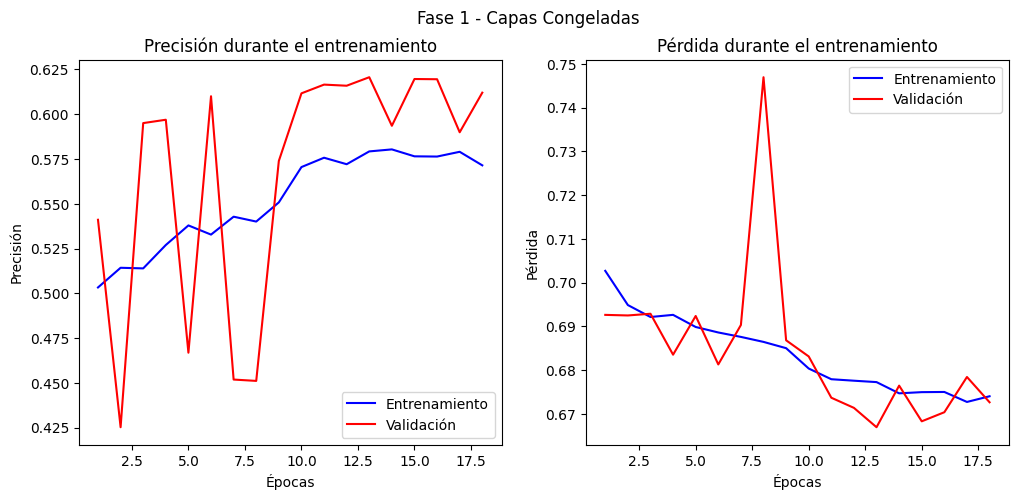

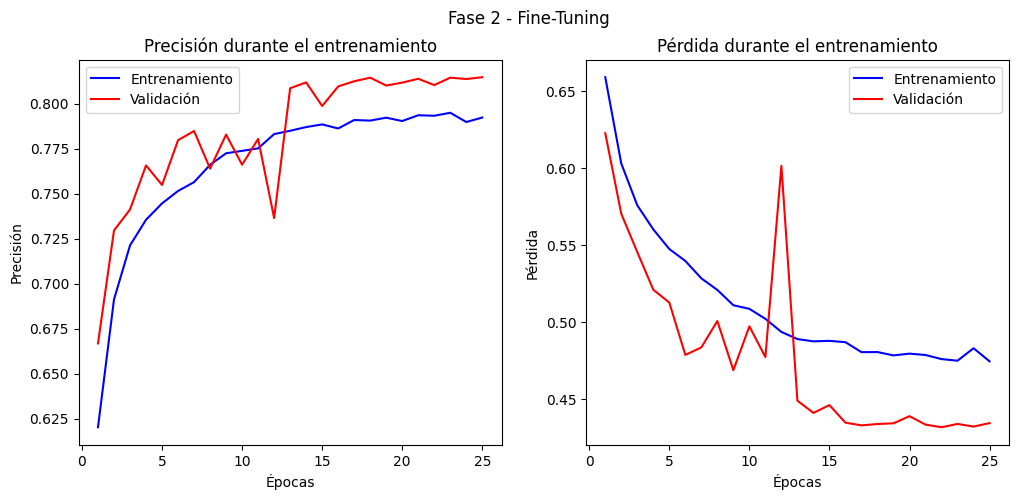

In [ ]:
import matplotlib.pyplot as plt

# Función para graficar precisión y pérdida
def plot_training_history(history, title="Histórico del entrenamiento"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Gráfica de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label="Entrenamiento")
    plt.plot(epochs, val_acc, 'r-', label="Validación")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.title("Precisión durante el entrenamiento")
    plt.legend()

    # Gráfica de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label="Entrenamiento")
    plt.plot(epochs, val_loss, 'r-', label="Validación")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title("Pérdida durante el entrenamiento")
    plt.legend()

    plt.suptitle(title)
    plt.show()

# Mostrar gráfico para ambas fases
plot_training_history(history_frozen, "Fase 1 - Capas Congeladas")
plot_training_history(history_unfrozen, "Fase 2 - Fine-Tuning")


MATRIZ DE CONFUSIÓN

1001/1001 [==============================] - 78s 75ms/step


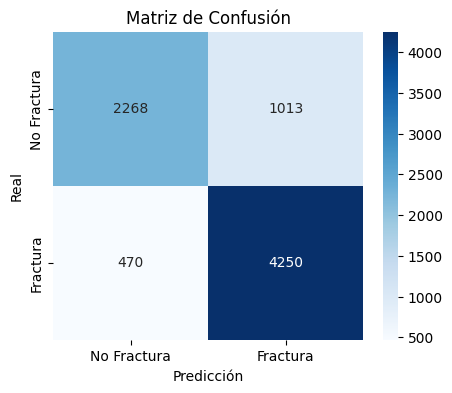

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener etiquetas reales y predicciones
y_true = valid_generator.classes
y_pred_probs = model.predict(valid_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Crear matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["No Fractura", "Fractura"],
            yticklabels=["No Fractura", "Fractura"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


CURVA ROC

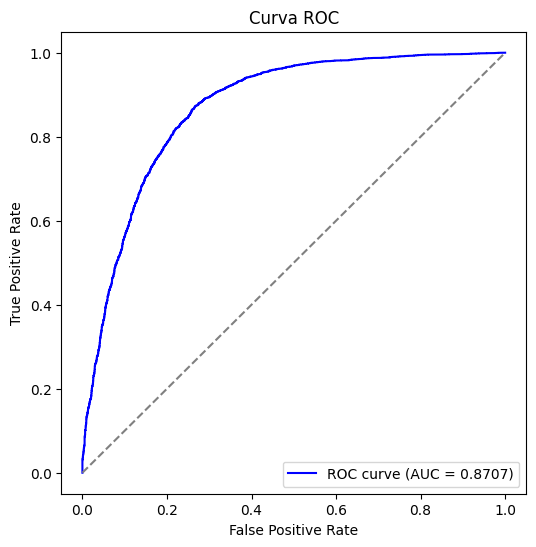

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Dibujar la curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()
